In [13]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from tensorflow_probability.substrates import jax as tfp
from sklearn.model_selection import train_test_split

tfd = tfp.distributions
plt.style.use('ggplot')
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
seed = 1234
np.random.seed(seed)
rng_key = jax.random.PRNGKey(42)

In [3]:
data_dir = "/home/xabush/code/snet/moses-incons-pen-xp/data"

In [4]:
def get_ess(chain, burn_in):
    c = chain
    l = c.shape[0]
    bi = int(burn_in * l)
    c = c[bi:]
    cv = tfp.mcmc.effective_sample_size(c)
    cv = cv.at[jnp.isnan(cv)].set(1.)
    return cv

def generate_betas(sz, tf, n_genes, val_tf, val_genes, num_pos=-1):
    if num_pos > n_genes:
        raise ValueError(f"Number of positive genes {num_pos} must be less than or equal to number of genes {n_genes}. To set all "
                         f"genes to positive, set it to -1")
    beta = np.zeros(sz)

    k = (tf + (tf * n_genes))
    st = n_genes + 1
    m = 0
    for i in range(k):
        if i % st == 0:
            beta[i] = val_tf[m]
            z = 0
            for j in range(i + 1, i + st):
                if num_pos < 0:
                    beta[j] = val_tf[m]/val_genes
                else:
                    if z < num_pos:
                        beta[j] = val_tf[m]/val_genes
                    else:
                        beta[j] = -val_tf[m]/val_genes
                    z += 1
            m += 1

    return beta

def generate_data_v2(tf, genes, tf_on=4, corr=0.7, val_tf=None, val_gene=np.sqrt(10), num_pos=-1, n=100):
    if val_tf is None:
        val_tf = [2, 2, 2, 2]
    sz = (tf + (tf * genes))
    X = np.zeros((n, sz))
    assert len(val_tf) == tf_on
    m = genes + 1
    for t in range(0, m*tf, m):
        X_tf = np.random.normal(0, 1, size=n)
        X[:,t] = X_tf
        for g in range(t + 1, t + m):
            X_g = np.random.normal(corr*X_tf, 0.51, size=n)
            X[:,g] = X_g

    beta = generate_betas(sz, tf_on, genes, val_tf, val_gene, num_pos=num_pos)

    sd_e = np.sqrt(np.sum(np.square(beta)) / 4)
    err = np.random.normal(np.zeros(n), sd_e, size=n)

    y = (X @ beta) + err

    return X, beta, y, sd_e


def generate_log_data(tf, genes, tf_on=4, corr=0.7, val_tf=None, val_gene=np.sqrt(10), num_pos=-1, n=100):
    if val_tf is None:
        val_tf = [2, 2, 2, 2]
    if val_tf is None:
        val_tf = [2, 2, 2, 2]
    sz = (tf + (tf * genes))
    X = np.zeros((n, sz))
    assert len(val_tf) == tf_on
    m = genes + 1
    for t in range(0, m*tf, m):
        X_tf = np.random.normal(0, 1, size=n)
        X[:,t] = X_tf
        for g in range(t + 1, t + m):
            X_g = np.random.normal(corr*X_tf, 0.51, size=n)
            X[:,g] = X_g

    beta = generate_betas(sz, tf_on, genes, val_tf, val_gene, num_pos=num_pos)

    y_dist = tfd.Bernoulli(logits=(X @ beta))
    print(y_dist)
    y_log = y_dist.sample(seed=rng_key)

    return X, beta, y_log

def get_assoc_mat(tf, genes, bias=False):
    feats = tf + (tf * genes)
    assoc_mat = np.eye(feats, feats)
    m = genes + 1
    for t in range(0, m * tf, m):
        for g in range(t + 1, t + m):
            assoc_mat[t, g] = 1
            assoc_mat[g, t] = 1
    if bias:
        zero_col = np.zeros((assoc_mat.shape[0], 1))
        zero_row = np.zeros((1, assoc_mat.shape[0] + 1))
        assoc_mat = np.hstack((zero_col, assoc_mat))
        return np.vstack((zero_row, assoc_mat))
    return assoc_mat

In [5]:
from typing import Callable, NamedTuple, Tuple
from blackjax.types import PRNGKey, PyTree

class MixedMALAPosition(NamedTuple):
    discrete_position: PyTree
    contin_position: PyTree

class MixedMALAState(NamedTuple):
    """Holds info about the discrete and the continuous r.vs in the mixed support"""

    position: MixedMALAPosition

    disc_logprob: float
    contin_logprob: float

    discrete_logprob_grad: PyTree
    contin_logprob_grad: PyTree

    disc_step_size: float
    contin_step_size: float

/home/xabush/miniconda3/lib/python3.9/site-packages/chex/_src/pytypes.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


In [6]:
from typing import Callable, NamedTuple
from blackjax.types import PRNGKey, PyTree


class MixedMALAState(NamedTuple):
    """Holds info about the discrete and the continuous r.vs in the mixed support"""

    discrete_position: PyTree
    contin_position: PyTree

    disc_logprob: float
    contin_logprob: float

    discrete_logprob_grad: PyTree
    contin_logprob_grad: PyTree

    disc_step_size: float
    contin_step_size: float


from blackjax.mcmc.diffusion import generate_gaussian_noise
from blackjax.mcmc.mala import MALAState

EPS = 1e-10


def diff_fn(state, step_size):
    theta = jax.tree_util.tree_map(lambda x, g: -0.5 * (g) * (2. * x - 1) - (1. / (2. * step_size)),
                                   state.position, state.logprob_grad)

    return jax.nn.sigmoid(theta)


def take_discrete_step(rng_key: PRNGKey, disc_state: MALAState, contin_state: MALAState,
                       logprob_fn: Callable, disc_grad_fn: Callable,
                       step_size: float) -> MALAState:
    _, key_rmh, key_accept = jax.random.split(rng_key, 3)
    theta_cur = disc_state.position

    u = jax.random.uniform(key_rmh, shape=disc_state.position.shape)
    p_curr = diff_fn(disc_state, step_size)
    ind = jnp.array(u < p_curr)
    pos_new = (1. - theta_cur) * ind + theta_cur * (1. - ind)

    logprob_new = logprob_fn(pos_new, contin_state.position)
    logprob_grad_new = disc_grad_fn(pos_new, contin_state.position)
    new_state = MALAState(pos_new, logprob_new, logprob_grad_new)  # No metropolis update just accept the move

    return new_state


def take_contin_step(rng_key: PRNGKey, disc_state: MALAState, contin_state: MALAState,
                     logprob_fn: Callable, contin_grad_fn: Callable,
                     step_size: float) -> MALAState:
    key_integrator, key_rmh = jax.random.split(rng_key)
    noise = generate_gaussian_noise(key_integrator, contin_state.position)
    new_position = jax.tree_util.tree_map(
        lambda p, g, n: p + step_size * g + jnp.sqrt(2 * step_size) * n,
        contin_state.position,
        contin_state.logprob_grad,
        noise,
    )

    logprob_new = logprob_fn(disc_state.position, new_position)
    logprob_grad_new = contin_grad_fn(disc_state.position, new_position)
    new_state = MALAState(new_position, logprob_new, logprob_grad_new)

    return new_state


def one_step(
        rng_key: PRNGKey, state: MixedMALAState,
        discrete_logprob_fn: Callable, contin_logprob_fn: Callable,
        discrete_step_size: float, contin_step_size: float
) -> MixedMALAState:
    disc_grad_fn = jax.grad(discrete_logprob_fn)
    contin_grad_fn = jax.grad(contin_logprob_fn, argnums=1)
    # Evolve each variable in tandem and combine the results

    disc_state = MALAState(state.discrete_position, state.disc_logprob, state.discrete_logprob_grad)
    contin_state = MALAState(state.contin_position, state.contin_logprob, state.contin_logprob_grad)
    # print(f"disc pos: {disc_state.position}, contin pos: {contin_state.position}")
    # Take a step for the discrete variable - sample from p(discrete | contin)

    new_disc_state = take_discrete_step(rng_key, disc_state, contin_state,
                                        discrete_logprob_fn, disc_grad_fn, discrete_step_size)
    # Take a step for the contin variable - sample from p(contin | new_discrete)
    new_contin_state = take_contin_step(rng_key, new_disc_state, contin_state,
                                        contin_logprob_fn, contin_grad_fn, contin_step_size)

    new_state = MixedMALAState(new_disc_state.position, new_contin_state.position,
                               new_disc_state.logprob, new_contin_state.logprob,
                               new_disc_state.logprob_grad, new_contin_state.logprob_grad,
                               discrete_step_size, contin_step_size)

    return new_state

def init(disc_position: PyTree,contin_position: PyTree,
         disc_logprob_fn: Callable, contin_logprob_fn: Callable,
         init_disc_step: float, init_contin_step: float) -> MixedMALAState:

    disc_logprob, disc_grad_logprob = jax.value_and_grad(disc_logprob_fn)(disc_position, contin_position)
    contin_logprob, contin_grad_logprob = jax.value_and_grad(contin_logprob_fn, argnums=1)(disc_position, contin_position)

    return MixedMALAState(disc_position, contin_position,
                          disc_logprob, contin_logprob,
                          disc_grad_logprob, contin_grad_logprob,
                          init_disc_step, init_contin_step)


In [7]:
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import roc_auc_score, mean_squared_error
import warnings

warnings.filterwarnings("ignore")

def run_fs_reg(X_train, X_test, y_train, y_test, feats, binary):
    results = {"cv_score": [], "test_score": []}

    X_s_train, X_s_test = X_train[:,np.array(feats, dtype=np.int32)].astype(np.int64), X_test[:,np.array(feats, dtype=np.int32)].astype(np.int64)
    # y_train, y_test = y_train.astype(np.int64), y_test.astype(np.int64)
    if feats.size == 1:
        X_s_train, X_s_test = X_s_train.reshape(-1, 1), X_s_test.reshape(-1, 1)

    if binary:
        cv_score = np.mean(cross_val_score(LogisticRegression(), X_s_train, y_train, scoring="roc_auc"))
        log_est = LogisticRegression(max_iter=1000).fit(X_s_train, y_train)
        test_score = roc_auc_score(y_test, log_est.predict_proba(X_s_test)[:,1])
    else:
        cv_score = -np.mean(cross_val_score(LinearRegression(), X_s_train, y_train, scoring="neg_root_mean_squared_error"))
        lin_est = LinearRegression().fit(X_s_train, y_train)
        test_score = mean_squared_error(y_test, lin_est.predict(X_s_test), squared=False)
    # print({"moses_cv_score": cv_score, "moses_test_score": test_score, "log_cv_score": cv_score, "log_test_score": test_score})
    results["cv_score"].append(cv_score)
    results["test_score"].append(test_score)

    return results

def run_param_sel_exp(*, key, X_train, X_test, y_train, y_test, J, vals,
            disc_dist, contin_dist, disc_step_size, contin_step_size,
            binary):

    num_samples = 10000
    num_chains = 3
    burn_in = 0.1
    p = J.shape[0]
    thresholds = np.round(np.linspace(0.1, 0.9, 9), decimals=1)
    res_dict = {"eta": [], "mu": [], "thres": [], "cv_score": [], "test_score": [], "len": [], "num_edges": [],
                "beta_cv_score": [], "beta_test_score": [] }
    for i, eta in enumerate(tqdm(vals)):
        for j, mu in enumerate(vals):
            # print(f"eta - {eta:.2f}, mu - {mu:.2f}")

            disc_init_pos = disc_dist.sample(seed=key, sample_shape=(num_chains,)) * 1.
            contin_init_pos = contin_dist.sample(seed=key, sample_shape=(num_chains,))

            disc_logprob = generate_disc_logprob_fn(X_train, y_train, J, mu, eta)
            contin_logprob = generate_contin_logprob_fn(X_train, y_train, tau, c)
            kernel = jax.jit(lambda key, state: one_step(key, state, disc_logprob, contin_logprob, disc_step_size, contin_step_size))

            init_state = jax.vmap(init, in_axes=(0, 0, None, None, None, None))(disc_init_pos, contin_init_pos, disc_logprob,
                                                                                contin_logprob,
                                                                                disc_step_size, contin_step_size)
            states = inference_loop_multiple_chains(rng_key, kernel, init_state, num_samples=num_samples, num_chains=num_chains)

            gamma_samples = states.discrete_position[int(burn_in*num_samples):]
            beta_samples = states.contin_position[int(burn_in*num_samples):]
            gamma_samples = gamma_samples.reshape(-1, p)
            beta_samples = beta_samples.reshape(-1, p)

            for t in thresholds:
                res_dict["eta"].append(eta)
                res_dict["mu"].append(mu)
                res_dict["thres"].append(t)
                idx = jnp.squeeze(jnp.argwhere((jnp.mean(gamma_samples, axis=0) > t)))

                num_edges = jnp.count_nonzero(J[idx,:][:,idx]) if idx.size > 1 else 0


                res_dict["len"].append(idx.size)
                res_dict["num_edges"].append(num_edges)

                if idx.size > 0:
                    res_idx_df = run_fs_reg(X_train, X_test, y_train, y_test, idx, binary)

                    res_dict["cv_score"].append(res_idx_df["cv_score"][0])
                    res_dict["test_score"].append(res_idx_df["test_score"][0])

                    beta_sel = jnp.mean(beta_samples[:,idx], axis=0)

                    if idx.size == 1:
                        beta_sel = beta_sel.reshape(-1, 1)
                        X_train_idx_sel = X_train[:,idx].reshape(-1, 1)
                        X_test_idx_sel = X_test[:,idx].reshape(-1, 1)

                    else:
                        X_train_idx_sel = X_train[:,idx]
                        X_test_idx_sel = X_test[:,idx]

                    train_roc = roc_auc_score(y_train, jax.nn.sigmoid((X_train_idx_sel @ beta_sel)))
                    test_roc = roc_auc_score(y_test, jax.nn.sigmoid((X_test_idx_sel @ beta_sel)))
                    res_dict["beta_cv_score"].append(train_roc)
                    res_dict["beta_test_score"].append(test_roc)

                else:
                    res_dict["cv_score"].append(np.nan)
                    res_dict["test_score"].append(np.nan)
                    res_dict["beta_cv_score"].append(np.nan)
                    res_dict["beta_test_score"].append(np.nan)

    res_df = pd.DataFrame(res_dict)

    print(f"========= Done for seed - {seed} =========")

    return res_df

In [8]:

def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

def inference_loop_multiple_chains(rng_key, kernel, initial_state, num_samples, num_chains):

    def one_step(states, rng_key):
        keys = jax.random.split(rng_key, num_chains)
        states = jax.vmap(kernel)(keys, states)
        return states, states

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [9]:

def gamma_energy(theta, J, eta, mu):
    xg = theta.T @ J
    xgx = xg @ theta
    return eta*xgx - mu*jnp.sum(theta)

def generate_disc_logprob_fn(X, y, J, mu, eta):

    def discrete_logprob_fn(gamma, pos):
        beta, sigma = pos["beta"], pos["sigma"]
        sigma = jax.nn.softplus(sigma) # ensure sigma is always positive
        X_gamma = (X @ jnp.diag(gamma))
        ising_logp = gamma_energy(gamma, J, eta, mu)
        log_ll = -jnp.sum(((y - (X_gamma @ beta)) ** 2) /  2 * (sigma ** 2))

        return ising_logp + log_ll

    return discrete_logprob_fn


def generate_contin_logprob_fn(X, y, tau, c):
    n, p = X.shape
    cov = X.T @ X
    # R = np.identity(p)
    # R = jnp.linalg.pinv(cov)
    v, l = 1., 1.

    def contin_logprob_fn(gamma, pos):
        beta, sigma = pos["beta"], pos["sigma"]
        # beta = pos["beta"]
        sigma = jax.nn.softplus(sigma) # ensure sigma is always positive

        D = (gamma*c*tau) + (1 - gamma)*(tau)
        # A = D @ R @ D
        # D_inv = jnp.linalg.inv(jnp.diag(D))

        # A = jnp.linalg.inv((1./sigma**2)*cov + (D_inv @ R @ D_inv))
        # print(A.shape)
        # mu = (A * (1/sigma ** 2)) @ cov

        beta_dist = tfd.MultivariateNormalDiag(loc=jnp.zeros(p), scale_diag=D)
        # print(beta_dist)
        beta_logp = beta_dist.log_prob(beta)
        # print(f"beta logp: {beta_logp}")
        log_ll_1 = jnp.abs(jnp.sum((y - (X @ beta)) ** 2))
        log_ll_2 = jnp.abs(jnp.sum((y - (X @ (beta * gamma))) ** 2))
        sigma_dist = tfd.InverseGamma(concentration=(n + v)/2, scale=(log_ll_1 + v*l)/2)
        sigma_logp = sigma_dist.log_prob(sigma)
        # print(f"sigma logp: {sigma_logp}")
        return beta_logp + sigma_logp

    return contin_logprob_fn


In [218]:

np.random.seed(1234)
X_lin, beta_true_lin, y_lin, sigma_true_lin = generate_data_v2(20, 10, tf_on=4, val_tf=[5, 5, 5, 5], corr=0.7, n=100)
X_train_lin, X_test_lin, y_train_lin, y_test_lin = train_test_split(X_lin, y_lin, test_size=0.3, shuffle=True)
J = get_assoc_mat(20, 10)
np.fill_diagonal(J, 0.)
p = J.shape[1]

In [230]:
tau, c = 0.01, 2500.
init_sigma_dist = tfd.InverseGamma(1., 1.)
init_beta_dist = tfd.MultivariateNormalDiag(loc=jnp.zeros(p), scale_diag=10*jnp.ones(p))
init_gamma_dist = tfd.Bernoulli(probs=0.5*jnp.ones(p))
eta, mu = 2.5, 10.0
init_beta = init_beta_dist.sample(seed=rng_key)
init_sigma = jax.nn.softplus(init_sigma_dist.sample(seed=rng_key))
init_gamma = init_gamma_dist.sample(seed=rng_key)*1.

contin_init_pos = {"beta": init_beta, "sigma": init_sigma}
# contin_init_pos = {"beta": init_beta}
disc_init_pos = init_gamma

disc_logprob = generate_disc_logprob_fn(X_train_lin, y_train_lin, J, mu, eta)
init_disc_logp = disc_logprob(disc_init_pos, contin_init_pos)

init_disc_grad = jax.grad(disc_logprob)(disc_init_pos, contin_init_pos)
contin_logprob = generate_contin_logprob_fn(X_train_lin, y_train_lin, tau, c)
init_contin_logp = contin_logprob(disc_init_pos ,contin_init_pos)
#
init_contin_grad = jax.grad(contin_logprob, argnums=1)(disc_init_pos, contin_init_pos)

In [231]:
init_contin_logp

DeviceArray(-51866588., dtype=float32)

In [232]:
disc_step_size = 0.1
contin_step_size = 1e-5
n_steps = 10000
init_state = MixedMALAState(disc_init_pos, contin_init_pos, init_disc_logp, init_contin_logp,
                               init_disc_grad, init_contin_grad, disc_step_size, contin_step_size)

kernel_lin = jax.jit(lambda key, state : one_step(key, state, disc_logprob, contin_logprob, disc_step_size, contin_step_size))
states = inference_loop(rng_key, kernel_lin, init_state, n_steps)

Text(0.5, 1.0, '$\\sigma_t = $ 7.071')

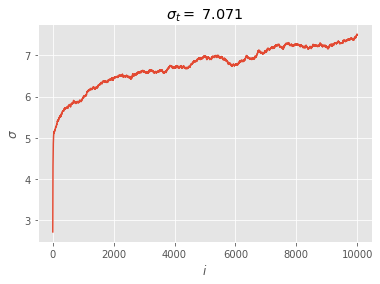

In [233]:
plt.plot(states.contin_position["sigma"])
plt.xlabel(r"$i$")
plt.ylabel(r"$\sigma$")
plt.title(r"$\sigma_t = $ {s:.3f}".format(s=sigma_true_lin))

In [234]:
beta_pos = states.contin_position["beta"]
gamma_pos = states.discrete_position

In [235]:
beta_pos

DeviceArray([[ 6.7195220e+00, -1.5035705e+01,  8.3865576e+00, ...,
               2.5128343e+00, -2.7987025e+00,  9.4682884e+00],
             [ 6.7227516e+00, -1.3527521e+01,  8.3846912e+00, ...,
               2.2633059e+00, -2.5159209e+00,  8.5171509e+00],
             [ 6.0535808e+00, -1.3521518e+01,  7.5475373e+00, ...,
               2.0350771e+00, -2.2716188e+00,  8.5117416e+00],
             ...,
             [ 2.2371154e+00,  3.4500524e-01,  3.7417510e+00, ...,
               3.5266001e-02,  4.1673797e-01,  1.3348281e-02],
             [ 2.2360075e+00,  3.4773147e-01,  3.7443020e+00, ...,
               3.9230101e-02,  4.1939455e-01,  9.2439819e-03],
             [ 2.2353423e+00,  3.4716403e-01,  3.7440910e+00, ...,
               3.8593922e-02,  4.1550171e-01,  9.7414497e-03]],            dtype=float32)

In [236]:
beta_gamma = beta_pos * gamma_pos
beta_gamma_mean = jnp.mean(beta_gamma, axis=0)

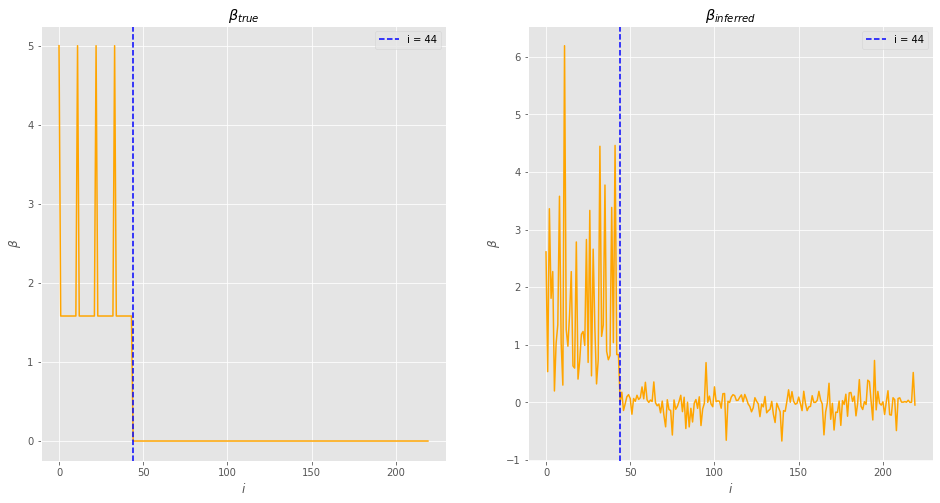

In [237]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(np.arange(0, p), beta_true_lin, color="orange")
ax[0].axvline(x=44, linestyle="--", color="blue", label="i = 44")
ax[0].set_title(r"$\beta_{true}$")
ax[0].set_xlabel(r"$i$")
ax[0].set_ylabel(r"$\beta$")
ax[0].legend()

ax[1].plot(np.arange(0, p), beta_gamma_mean, color="orange")
ax[1].axvline(x=44, linestyle="--", color="blue", label="i = 44")
ax[1].set_title(r"$\beta_{inferred}$")
ax[1].set_xlabel(r"$i$")
ax[1].set_ylabel(r"$\beta$")
ax[1].legend()

In [238]:

idx_lin = jnp.squeeze(jnp.argwhere(jnp.mean(gamma_pos, axis=0) > 0.9))
print(len(idx_lin))
idx_lin

107


DeviceArray([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
              12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,
              24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
              36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  55,
              57,  59,  64,  66,  70,  71,  75,  77,  81,  83,  85,  87,
              88,  90,  92,  95,  99, 100, 105, 107, 110, 112, 118, 121,
             122, 127, 130, 131, 132, 133, 135, 136, 139, 140, 143, 153,
             154, 165, 166, 169, 171, 175, 176, 179, 184, 186, 187, 188,
             191, 192, 194, 195, 198, 201, 203, 204, 208, 209, 218],            dtype=int32)

In [239]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
clf = LinearRegression()
clf.fit(X_train_lin[:,idx_lin], y_train_lin)

print(f"train rmse: {mean_squared_error(y_train_lin, clf.predict(X_train_lin[:,idx_lin]), squared=False)}\n test rmse: {mean_squared_error(y_test_lin, clf.predict(X_test_lin[:,idx_lin]), squared=False)} ")

train rmse: 5.195203371946907e-14
 test rmse: 11.8541264064528 


### Try it with binary output data

In [11]:
X_log, beta_true_log, y_log = generate_log_data(20, 10, tf_on=4, val_tf=[5, 5, 5, 5], corr=0.7, n=100)
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, y_log, test_size=0.3, shuffle=True)

tfp.distributions.Bernoulli("Bernoulli", batch_shape=[100], event_shape=[], dtype=int32)


In [23]:
disc_step_size = 0.1
contin_step_size = 1e-5
n_steps = 10000

def generate_disc_logprob_fn(X, y, J, mu, eta):

    def discrete_logprob_fn(gamma, beta):
        X_gamma = (X @ jnp.diag(gamma))
        ising_logp = gamma_energy(gamma, J, eta, mu)
        ll_dist = tfd.Bernoulli(logits=(X_gamma @ beta))
        log_ll = jnp.sum(ll_dist.log_prob(y), axis=0)

        # print(f"gamma logp: {ising_logp}, log_ll: {log_ll}")

        return ising_logp + log_ll

    return discrete_logprob_fn


def generate_contin_logprob_fn(X, y, tau, c):
    n, p = X.shape
    cov = X.T @ X
    R = np.identity(p)
    v, l = 1., 1.

    def contin_logprob_fn(gamma, beta):

        D = (gamma*c*tau) + (1 - gamma)*(tau)
        # D_inv = jnp.linalg.inv(jnp.diag(D))

        # A = jnp.linalg.inv((1./sigma**2)*cov + (D_inv @ R @ D_inv))
        beta_dist = tfd.MultivariateNormalDiag(loc=jnp.zeros(p), scale_diag=D)
        # print(beta_dist.sample(seed=rng_key))
        beta_logp = beta_dist.log_prob(beta)
        X_gamma = (X @ jnp.diag(gamma))
        ll_dist = tfd.Bernoulli(logits=(X_gamma @ beta))
        log_ll = jnp.sum(ll_dist.log_prob(y), axis=0)

        # print(f"beta logp: {beta_logp}, log_ll: {log_ll}")

        return beta_logp + log_ll

    return contin_logprob_fn


In [16]:
param_vals = np.logspace(-1, 1, 10)
param_vals = np.insert(param_vals, 0, 0.)

In [17]:
init_sigma_dist = tfd.InverseGamma(1., 1.)
init_beta_dist = tfd.MultivariateNormalDiag(loc=jnp.zeros(p), scale_diag=10*jnp.ones(p))
init_gamma_dist = tfd.Bernoulli(probs=0.5*jnp.ones(J.shape[0]))
res_log_df = run_param_sel_exp(key=rng_key, X_train=X_train_log, X_test=X_test_log, y_train=y_train_log, y_test=y_test_log, J=J, vals=param_vals, disc_dist=init_gamma_dist, contin_dist=init_beta_dist,
                               disc_step_size=disc_step_size, contin_step_size=contin_step_size, binary=True)

100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [13:15<00:00, 72.34s/it]


========= Done for seed - 1234 =========


In [20]:
res_log_df.to_csv(f"{data_dir}/res_sim_data_log_gibbs.csv", index=False)

In [240]:
res_log_df.sort_values(by="beta_test_score", axis=0, ascending=False)

,eta,mu,thres,cv_score,test_score,len,num_edges,beta_cv_score,beta_test_score
345,0.278256,0.774264,0.4,0.709184,0.837104,157,274,0.984477,0.990950
344,0.278256,0.774264,0.3,0.676786,0.877828,220,400,0.988562,0.986425
317,0.278256,0.166810,0.3,0.676786,0.877828,220,400,0.994281,0.986425
311,0.278256,0.100000,0.6,0.664456,0.918552,127,214,0.996732,0.986425
130,0.100000,0.278256,0.5,0.811480,0.782805,50,60,0.967320,0.986425
...,...,...,...,...,...,...,...,...,...
886,3.593814,10.000000,0.5,NaN,NaN,0,0,NaN,NaN
887,3.593814,10.000000,0.6,NaN,NaN,0,0,NaN,NaN
888,3.593814,10.000000,0.7,NaN,NaN,0,0,NaN,NaN
889,3.593814,10.000000,0.8,NaN,NaN,0,0,NaN,NaN


In [30]:
disc_init_pos = init_gamma_dist.sample(seed=rng_key, sample_shape=(3,)) * 1.
contin_init_pos = init_beta_dist.sample(seed=rng_key, sample_shape=(3,))
burn_in = 0.1
num_samples = 10000
p = J.shape[0]
eta, mu = 0.1, 0.278256
disc_logprob = generate_disc_logprob_fn(X_train_log, y_train_log, J, mu, eta)
contin_logprob = generate_contin_logprob_fn(X_train_log, y_train_log, tau, c)
kernel = jax.jit(
    lambda key, state: one_step(key, state, disc_logprob, contin_logprob, disc_step_size, contin_step_size))

init_state = jax.vmap(init, in_axes=(0, 0, None, None, None, None))(disc_init_pos, contin_init_pos, disc_logprob,
                                                                    contin_logprob,
                                                                    disc_step_size, contin_step_size)
states = inference_loop_multiple_chains(rng_key, kernel, init_state, num_samples=num_samples, num_chains=3)

gamma_samples = states.discrete_position[int(burn_in * num_samples):]
beta_samples = states.contin_position[int(burn_in * num_samples):]
gamma_samples = gamma_samples.reshape(-1, p)
beta_samples = beta_samples.reshape(-1, p)
idx_log = jnp.squeeze(jnp.argwhere(jnp.mean(gamma_samples, axis=0) > 0.6))
idx_log

DeviceArray([  0,  11,  14,  22,  33,  40,  55,  66,  77,  88,  99, 110,
             121, 132, 143, 154, 165, 176, 187, 198, 209], dtype=int32)

In [58]:
res_log_df.iloc[res_log_df["test_score"].idxmax()]

eta                 1.29155
mu                 2.154435
thres                   0.6
cv_score           0.639711
test_score         0.972851
len                     143
num_edges               246
beta_cv_score      0.990196
beta_test_score    0.877828
Name: 662, dtype: object

### BMM Data

In [10]:
%cd "~/code/snet/moses-incons-pen-xp"
from notebooks.variable_selection.util import load_bmm_files
seeds, data_dfs, net_dfs, feats = load_bmm_files("data/bmm_data_thr_2_f100")

/home/xabush/code/snet/moses-incons-pen-xp


In [11]:
seed_idx = 5
seed = seeds[seed_idx]
rng_key = jax.random.PRNGKey(seed)
feat = feats[seed_idx]
data_df = data_dfs[seed_idx]
net_df = net_dfs[seed_idx]

In [14]:
X_bmm_10, y_bmm_10 = data_df.iloc[:,:-1], data_df["y"]
X_train_bmm_10, X_test_bmm_10, y_train_bmm_10, y_test_bmm_10 = train_test_split(X_bmm_10, y_bmm_10, test_size=0.3, random_state=seed, shuffle=True, stratify=y_bmm_10)

In [16]:
J_bmm_10 = jax.device_put(net_df.to_numpy())

In [45]:
disc_step_size = 0.1
contin_step_size = 1e-5
tau, c = 0.01, 1000
p = J_bmm_10.shape[0]
beta_dist = tfd.MultivariateNormalDiag(loc=jnp.zeros(p), scale_diag=10*jnp.ones(p))
gamma_dist = tfd.Bernoulli(probs=0.5*jnp.ones(p))
X_train, X_test = jnp.array(X_train_bmm_10.to_numpy()), jnp.array(X_test_bmm_10.to_numpy())
y_train, y_test = jnp.array(y_train_bmm_10.to_numpy()), jnp.array(y_test_bmm_10.to_numpy())

In [76]:

res_bmm_s_10_df = run_param_sel_exp(key=rng_key, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, J=J_bmm_10,
                               vals=param_vals, disc_dist=gamma_dist, contin_dist=beta_dist,
                               disc_step_size=disc_step_size, contin_step_size=contin_step_size, binary=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [19:31<00:00, 106.54s/it]

========= Done for seed - 10 =========


In [ ]:
res_bmm_s_10_df.to_csv(f"{data_dir}/res_bmm_s_10_gibbs_ula.csv", index=False)

In [17]:
res_bmm_s_10_df = pd.read_csv(f"{data_dir}/res_bmm_s_10_gibbs_ula.csv")

FileNotFoundError: [Errno 2] No such file or directory: '/home/xabush/code/snet/moses-incons-pen-xp/data/res_bmm_s_10_gibbs_ula.csv'

In [77]:
res_bmm_s_10_df.sort_values(by="test_score", axis=0, ascending=False)

,eta,mu,thres,cv_score,test_score,len,num_edges,beta_cv_score,beta_test_score
111,0.100000,0.10000,0.4,0.646145,0.646577,69,1648,0.731620,0.636765
308,0.278256,0.10000,0.3,0.630915,0.642264,71,1740,0.742633,0.632237
23,0.000000,0.16681,0.6,0.696368,0.640755,4,2,0.713157,0.635364
317,0.278256,0.16681,0.3,0.631944,0.638706,72,1796,0.731757,0.643235
299,0.278256,0.00000,0.3,0.631944,0.638706,72,1796,0.735408,0.629111
...,...,...,...,...,...,...,...,...,...
493,0.464159,10.00000,0.8,NaN,NaN,0,0,NaN,NaN
494,0.464159,10.00000,0.9,NaN,NaN,0,0,NaN,NaN
591,0.774264,10.00000,0.7,NaN,NaN,0,0,NaN,NaN
592,0.774264,10.00000,0.8,NaN,NaN,0,0,NaN,NaN


In [243]:
res_bmm_s_10_df.sort_values(by="beta_test_score", axis=0, ascending=False)

NameError: name 'res_bmm_s_10_df' is not defined

In [141]:
X_train, X_test = jnp.array(X_train_bmm_10.to_numpy()), jnp.array(X_test_bmm_10.to_numpy())
y_train, y_test = jnp.array(y_train_bmm_10.to_numpy()), jnp.array(y_test_bmm_10.to_numpy())
n_chains = 3
disc_init_pos = gamma_dist.sample(seed=rng_key, sample_shape=(n_chains,)) * 1.
contin_init_pos = beta_dist.sample(seed=rng_key, sample_shape=(n_chains,))
burn_in = 0.1
num_samples = 10000
p = J_bmm_10.shape[0]
eta, mu = 0.1, 0.1
disc_logprob = generate_disc_logprob_fn(X_train, y_train, J_bmm_10, mu, eta)
contin_logprob = generate_contin_logprob_fn(X_train, y_train, tau, c)
kernel = jax.jit(lambda key, state: one_step(key, state, disc_logprob, contin_logprob, disc_step_size, contin_step_size))

init_state = jax.vmap(init, in_axes=(0, 0, None, None, None, None))(disc_init_pos, contin_init_pos, disc_logprob,
                                                                    contin_logprob,
                                                                    disc_step_size, contin_step_size)
states = inference_loop_multiple_chains(rng_key, kernel, init_state, num_samples=num_samples, num_chains=n_chains)

gamma_samples = states.discrete_position[int(burn_in*num_samples):]
beta_samples = states.contin_position[int(burn_in*num_samples):]
gamma_samples = gamma_samples.reshape(-1, p)
beta_samples = beta_samples.reshape(-1, p)

In [82]:
idx_1 = jnp.squeeze(jnp.argwhere(jnp.mean(gamma_samples, axis=0) > 0.6))
idx_1

DeviceArray([42, 58, 60, 92], dtype=int32)

In [147]:
idx_2 = jnp.squeeze(jnp.argwhere(jnp.mean(gamma_samples, axis=0) > 0.4))
idx_2

DeviceArray([ 0,  2,  4,  5,  6, 11, 12, 14, 15, 17, 18, 19, 20, 24, 25,
             26, 27, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 43,
             44, 45, 46, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 64,
             66, 67, 68, 70, 71, 73, 74, 78, 81, 82, 83, 84, 85, 86, 87,
             88, 90, 92, 94, 95, 96, 97, 98, 99], dtype=int32)

In [83]:
np.array(feat) - 1

array([58, 60, 92, 25, 79])

In [49]:
jax.device_get(J_bmm_10[idx_1,:][:,np.array(feat) - 1])

array([[ 0.      , -0.54721 ,  0.052118,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  1.0872  , -0.065148],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.012367,  0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.58806 ,  1.1641  ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.25027 ,  0.049183],
       [ 0.      ,  0.      ,  1.1449  ,  0.39703 ,  0.      ],
       [-0.52922 ,  1.05    ,  0.      ,  0.      ,  0.      ],
       [ 1.514   ,  0.      , -2.6742  ,  0.      , -0.64867 ],
       [ 0.      ,  0.      ,  0.      , -0.82846 ,  0.      ],
       [ 0.      ,  0.      ,  0.81707 ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      , -0.068902],
       [ 0.      ,  0.017719,  0.      ,  0.10958 ,  0.      ],
       [ 0.      ,  0.      ,  0.46703 ,  0.      ,  0.33502 ],
       [-1.0499  ,  0.19164 ,  0.11948 ,

In [83]:
%cd /home/xabush/code/snet/moses-incons-pen-xp
from notebooks.variable_selection.util import assign_cols
train_bmm_10_sel = assign_cols(X_train_bmm_10.iloc[:,idx_1], append_y=False)
train_bmm_10_sel = pd.concat([train_bmm_10_sel, y_train_bmm_10], axis=1)
train_bmm_10_sel.to_csv(f"{data_dir}/train_bmm_10_sel_gibbs_ula.csv", index=False)
train_bmm_10_sel.head()

/home/xabush/code/snet/moses-incons-pen-xp


,f1,f2,f3,f4,y
613,1,0,0,1,1
130,1,0,1,1,1
487,1,1,0,0,1
176,1,1,1,1,1
960,1,1,0,0,0


In [18]:
train_bmm_10_sel = pd.read_csv(f"{data_dir}/train_bmm_10_sel_gibbs_ula.csv")
train_bmm_10_sel

,f1,f2,f3,f4,y
0,1,0,0,1,1
1,1,0,1,1,1
2,1,1,0,0,1
3,1,1,1,1,1
4,1,1,0,0,0
...,...,...,...,...,...
695,1,1,0,1,1
696,1,1,1,0,1
697,1,1,1,1,1
698,1,0,1,0,1


In [148]:
X_train, X_test = X_train_bmm_10.to_numpy(), X_test_bmm_10.to_numpy()
y_train, y_test = y_train_bmm_10.to_numpy(), y_test_bmm_10.to_numpy()
X_train_sel, X_test_sel = X_train[:,idx_2], X_test[:,idx_2]
X_train_sel.shape

(700, 69)

In [209]:
%autoreload
from notebooks.variable_selection.MosesEstimator import *
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, KFold

def run_fs_moses(X_train, X_test, y_train, y_test, seed, feats=None):
    results = {"complexity_ratio": [], "moses_cv_score": [], "moses_test_score": []}
    complx_ratios = [5]
    cr = 5
    # tmps = np.logspace(3, 4, 5)
    tmps = [10]
    models = []
    if feats is None:
        X_s_train, X_s_test = X_train.astype(np.int64), X_test.astype(np.int64)
    else:
        X_s_train, X_s_test = X_train[:,feats].astype(np.int64), X_test[:,feats].astype(np.int64)
    y_train, y_test = y_train.astype(np.int64), y_test.astype(np.int64)
    print(X_s_train.shape)
    # MosesEstimator(fs_algo=None, random_state=seed).fit(X_s_train, y_train)
    cv = KFold(n_splits=5)

    for tmp in (pgbar := tqdm(tmps)):
        moses_opts = ["--complexity-temperature", f"{tmp}", "--hc-crossover-min-neighbors", "500", "--hc-crossover-pop-size",
                      "100", "--hc-fraction-of-nn", "2.0", "-e",
                      "or(and(or(and(or(!$39 !$47) $25) and($2 $4 $63) and(!$13 $28) !$14) or(and($27 !$44 $54) $43)) and(or(and($2 $33) and(!$37 $40)) or(!$11 !$28 !$31) $52) !$67)"]
        # cv_scores = []
        # j = 0
        # for train_idx, test_idx in cv.split(X_s_train, y_train):
        #     x_train_cv, x_test_cv = X_s_train[train_idx], X_s_train[test_idx]
        #     y_train_cv, y_test_cv = y_train[train_idx], y_train[test_idx]
        #     est = MosesEstimator(fs_algo=None, complexity_ratio=cr,
        #                          random_state=seed, ensemble=True, num_evals=20000).fit(x_train_cv, y_train_cv, moses_params=moses_opts)
        #
        #     score = MosesEstimator.score(est, x_test_cv, y_test_cv)
        #     print(f"fold - {j + 1} score: {score : .3f}")
        #     cv_scores.append(score)
        #     j += 1
        #
        # cv_scores = np.array(cv_scores)
        # cv_score = np.mean(cv_scores)

        moses_est_r = MosesEstimator(fs_algo=None, complexity_ratio=cr, num_models=100,
                                     random_state=seed, ensemble=False, num_evals=30000).fit(X_s_train, y_train, moses_params=moses_opts)

        train_score = MosesEstimator.score(moses_est_r, X_s_train, y_train)
        test_score = MosesEstimator.score(moses_est_r ,X_s_test, y_test)
        results["complexity_ratio"].append(tmp)
        results["moses_cv_score"].append(train_score)
        results["moses_test_score"].append(test_score)
        models.append(moses_est_r)
        # cv_score_2 = np.mean(cross_val_score(LogisticRegression(max_iter=1000), X_s_train, y_train, scoring=log_roc_auc))
        # log_est = LogisticRegression(max_iter=1000).fit(X_s_train, y_train)
        # test_score_2 = roc_auc_score(y_test, log_est.predict(X_s_test))
        # # print({"moses_cv_score": cv_score, "moses_test_score": test_score, "log_cv_score": cv_score_2, "log_test_score": test_score_2}
        #
        # results["log_cv_score"].append(cv_score_2)
        # results["log_test_score"].append(test_score_2)
        #
        pgbar.set_postfix({"cr": f"{tmp:.2f}", "moses_tr": f"{train_score:.4f}", "moses_te": f"{test_score:.4f}"})
    # moses_est_r.cleanup()

    return pd.DataFrame(results), models

In [210]:
res_df, models = run_fs_moses(X_train_sel, X_test_sel, y_train, y_test, seed)

(700, 69)


100%|████████████████████████████████████████████| 1/1 [03:15<00:00, 195.81s/it, cr=10.00, moses_tr=0.8562, moses_te=0.6078]


In [211]:
res_df

,complexity_ratio,moses_cv_score,moses_test_score
0,10,0.856154,0.607817


In [218]:
moses_est = MosesEstimator(ensemble=False)
moses_est.models_ = models[0].models_[:5]
print(moses_est.score(moses_est, X_train_sel, y_train))
print(moses_est.score(moses_est, X_test_sel, y_test))

0.8345082111265159
0.6055525606469002


In [208]:
models[0].models_[0].model

'or(and(or(and(or(!$f39 !$f47) $f25) and($f2 $f4 $f63) and(!$f13 $f28) !$f14) or(and($f27 !$f44 $f54) $f43)) and(or(and($f2 $f33) and(!$f37 $f40)) or(!$f11 !$f28 !$f31) $f52) !$f67)'

### Seed 55

In [101]:
seed_idx = 3
seed = seeds[seed_idx]
rng_key = jax.random.PRNGKey(seed)
feat = feats[seed_idx]
data_df = data_dfs[seed_idx]
net_df = net_dfs[seed_idx]
X_bmm, y_bmm = data_df.iloc[:, :-1], data_df["y"]
X_train_bmm, X_test_bmm, y_train_bmm, y_test_bmm = train_test_split(X_bmm, y_bmm, test_size=0.3, random_state=seed,
                                                                    shuffle=True, stratify=y_bmm)
X_train, X_test = jnp.array(X_train_bmm.to_numpy()), jnp.array(X_test_bmm.to_numpy())
y_train, y_test = jnp.array(y_train_bmm.to_numpy()), jnp.array(y_test_bmm.to_numpy())
J_bmm = jax.device_put(net_df.to_numpy())
disc_step_size = 0.1
contin_step_size = 1e-5
tau, c = 0.01, 2500
p = J_bmm.shape[0]
beta_dist = tfd.MultivariateNormalDiag(loc=jnp.zeros(p), scale_diag=10 * jnp.ones(p))
gamma_dist = tfd.Bernoulli(probs=0.5 * jnp.ones(p))

res_bmm_55_df = run_param_sel_exp(key=rng_key, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, J=J_bmm,
                               vals=param_vals, disc_dist=gamma_dist, contin_dist=beta_dist,
                               disc_step_size=disc_step_size, contin_step_size=contin_step_size, binary=True)

100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [14:05<00:00, 76.84s/it]

========= Done for seed - 92 =========


In [ ]:
res_bmm_55_df.to_csv(f"{data_dir}/res_bmm_s_55_gibbs_ula.csv", index=False)

In [102]:
res_bmm_55_df.sort_values(by="beta_test_score", axis=0, ascending=False)

,eta,mu,thres,cv_score,test_score,len,num_edges,beta_cv_score,beta_test_score
264,0.166810,2.154435,0.4,0.567228,0.634094,7,16,0.568656,0.652480
538,0.774264,0.464159,0.8,0.478239,0.584497,57,1076,0.634748,0.650550
531,0.774264,0.464159,0.1,0.535227,0.569288,69,1554,0.662515,0.648394
532,0.774264,0.464159,0.2,0.538932,0.583248,65,1364,0.662744,0.648054
263,0.166810,2.154435,0.3,0.612350,0.575304,9,32,0.599737,0.646124
...,...,...,...,...,...,...,...,...,...
589,0.774264,10.000000,0.5,NaN,NaN,0,0,NaN,NaN
590,0.774264,10.000000,0.6,NaN,NaN,0,0,NaN,NaN
591,0.774264,10.000000,0.7,NaN,NaN,0,0,NaN,NaN
592,0.774264,10.000000,0.8,NaN,NaN,0,0,NaN,NaN


In [96]:
disc_init_pos = gamma_dist.sample(seed=rng_key, sample_shape=(3,)) * 1.
contin_init_pos = beta_dist.sample(seed=rng_key, sample_shape=(3,))
burn_in = 0.1
num_samples = 10000
p = J_bmm.shape[0]
eta, mu = 0.16, 2.154
disc_logprob = generate_disc_logprob_fn(X_train, y_train, J_bmm, mu, eta)
contin_logprob = generate_contin_logprob_fn(X_train, y_train, tau, c)
kernel = jax.jit(lambda key, state: one_step(key, state, disc_logprob, contin_logprob, disc_step_size, contin_step_size))

init_state = jax.vmap(init, in_axes=(0, 0, None, None, None, None))(disc_init_pos, contin_init_pos, disc_logprob,
                                                                    contin_logprob,
                                                                    disc_step_size, contin_step_size)
states = inference_loop_multiple_chains(rng_key, kernel, init_state, num_samples=num_samples, num_chains=3)

gamma_samples = states.discrete_position[int(burn_in*num_samples):]
beta_samples = states.contin_position[int(burn_in*num_samples):]
gamma_samples = gamma_samples.reshape(-1, p)
beta_samples = beta_samples.reshape(-1, p)

In [100]:
idx_2 = jnp.squeeze(jnp.argwhere(jnp.mean(gamma_samples, axis=0) > 0.3))
idx_2

DeviceArray([ 7, 26, 34, 36, 52, 59, 72, 85, 88, 97], dtype=int32)

In [99]:
np.array(feat) - 1

array([45, 94, 72, 20, 79])

In [245]:
res_bmm_55_df

NameError: name 'res_bmm_55_df' is not defined